In [6]:
import pandas as pd
import numpy as np

import json
import wandb
import matplotlib.pyplot as plt
from datetime import datetime


from utils.ml_utils import metrics, ml
from utils.utils import make_table
from utils.wandb_logging import init_exp, log_params, finish_exp

import warnings
warnings.filterwarnings("ignore")

In [24]:
cols = ["account_id", "name", "point", "call_count", "total_call_time", "total_exclusive_time", "min_call_time", "max_call_time", "sum_of_squares", "instances", "language", "app_name", "app_id", "scope", "host", "display_host", "pid", "agent_version", "labels"]
data_raw = pd.read_csv("Data/metrics_collector.tsv", names = cols, sep="\t")

In [25]:
data = make_table(data_raw)

In [116]:
def calculate_weight(anomaly_dict: dict[str, pd.DataFrame], start: datetime, end: datetime) -> dict[str, int]:
    '''
    function return a weight on which we need to multiply predictions of models on period
    '''
    weights = {}

    for col_name, df in anomaly_dict.items():

        overall_var = data[col_name].var()
        overall_mean = data[col_name].mean()

        with_out_anomaly_var = np.mean((overall_mean - data[(data.time >= start) & (data.time <= end)][col_name])**2)

        weights[col_name] = with_out_anomaly_var / overall_var
        print(f'Column: {col_name}, Overall Variance: {overall_var}, Overall Mean: {overall_mean}, Without Anomaly Sum: {with_out_anomaly_var}')
    
    return weights

In [177]:
start_str = "2024-04-26 11:32:00"
end_str = "2024-04-28 11:58:00"
date_format = "%Y-%m-%d %H:%M:%S"

start_obj = datetime.strptime(start_str, date_format)
end_obj = datetime.strptime(end_str, date_format)

res = ml(data, start_obj, end_obj, column_names=["web_response", "throughput", "apdex", "error"])

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s finished


In [156]:
%%time
weights = calculate_weight(res, start_obj, end_obj)

Column: web_response, Overall Variance: 0.000388398328818089, Overall Mean: 0.014054376522158416, Without Anomaly Sum: 0.00015611627895546247
Column: throughput, Overall Variance: 1464579.4283636156, Overall Mean: 3624.7797536517833, Without Anomaly Sum: 2642037.262015677
Column: apdex, Overall Variance: 3.1235220184250507e-05, Overall Mean: 0.9985337442498524, Without Anomaly Sum: 1.9693548863271425e-06
Column: error, Overall Variance: 2.9563878510515153e-05, Overall Mean: 0.00033519405510003844, Without Anomaly Sum: 7.045508077208396e-07
CPU times: user 4.12 ms, sys: 1.27 ms, total: 5.39 ms
Wall time: 5.09 ms


In [157]:
weights

{'web_response': 0.40194889465804423,
 'throughput': 1.803956283182021,
 'apdex': 0.06304917572888233,
 'error': 0.023831474191393663}

In [158]:
res.keys()

dict_keys(['web_response', 'throughput', 'apdex', 'error'])

In [178]:
df = res["throughput"]

In [160]:
df[df.labels == 1].probability.sort_values()

240     0.996253
241     0.996253
247     0.996253
272     0.996253
273     0.996253
279     0.996253
282     0.996253
283     0.996253
628     1.000000
2068    1.000000
Name: probability, dtype: float64

In [161]:
df[df.labels == 0].probability.sort_values()

1959    0.000000
434     0.000000
433     0.000000
432     0.000000
431     0.000000
          ...   
267     0.978986
266     0.978986
265     0.978986
263     0.978986
257     0.978986
Name: probability, Length: 2897, dtype: float64

In [162]:
df.probability.sort_values()

482     0.000000
1828    0.000000
1829    0.000000
1830    0.000000
1831    0.000000
          ...   
282     0.996253
283     0.996253
241     0.996253
2068    1.000000
628     1.000000
Name: probability, Length: 2907, dtype: float64

In [179]:
df.probability = df.probability*1.28

In [164]:
df.columns

Index(['labels', 'probability', 'time', 'value'], dtype='object')

In [165]:
df.labels.value_counts()

labels
0    2897
1      10
Name: count, dtype: int64

In [166]:
df

,labels,probability,time,value
0,0,2.543067e-11,2024-04-26 11:32:00,4584.0
1,0,2.543067e-11,2024-04-26 11:33:00,4631.0
2,0,2.543067e-11,2024-04-26 11:34:00,4805.5
3,0,2.543067e-11,2024-04-26 11:35:00,4666.0
4,0,2.543067e-11,2024-04-26 11:36:00,4685.0
...,...,...,...,...
2902,0,3.727492e-01,2024-04-28 11:54:00,4199.5
2903,0,3.727492e-01,2024-04-28 11:55:00,4227.0
2904,0,3.727492e-01,2024-04-28 11:56:00,4023.0
2905,0,3.727492e-01,2024-04-28 11:57:00,3914.0


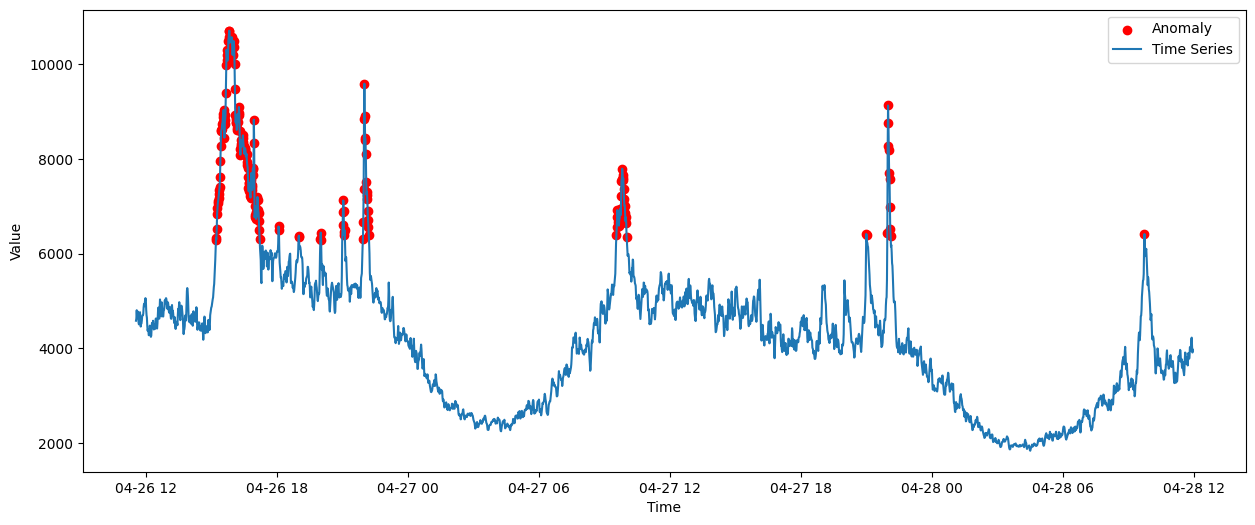

In [180]:
import matplotlib.pyplot as plt

# Создаем график
plt.figure(figsize=(15, 6))

df = df[(df.time >= start_obj) & (df.time <= end_obj)]

# Отмечаем аномалии красными точками
plt.scatter(df['time'][df['probability'] > 0.96], df['value'][df['probability'] > 0.96], color='red', label='Anomaly')

# Строим временной ряд
plt.plot(df['time'], df['value'], label='Time Series')

# Добавляем легенду
plt.legend()

# Добавляем названия осей
plt.xlabel('Time')
plt.ylabel('Value')

# Отображаем график
plt.show()

In [172]:
(1/(1 + np.exp(-1.8)))*2

1.7162978701990246

In [176]:
(1.8 / (1.8 + 1)) * 2

1.2857142857142858

In [43]:
config_model_name = "LOF"
metrics_dict = {}
timeseries_cols = ["web_response", "throughput", "apdex", "error"]

with open('config.json', 'r') as file:
    config = json.load(file)


for timeseries_col in timeseries_cols:
    model = LOF(**config[config_model_name][timeseries_col])

    # fit predict model 
    X = data_raw[["time", timeseries_col]]
    model.fit(X)
    predictions = model.predict(X)
    print(predictions)
    metrics_dict[timeseries_col] = metrics(X, predictions, timeseries_col)


    with open('secrets/wandb_secret.txt', 'r') as file:
        api_key = file.read()

    wandb.login(key=api_key)

    wandb.init(project="redlab-hack", tags=[config_model_name, timeseries_col])
    wandb.log(config[config_model_name][timeseries_col])
    wandb.log(metrics_dict)
    wandb.finish()

[1 1 1 ... 1 1 1]


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [ ]:
def train_model(data: pd.DataFrame, model, params: dict, start: pd.datetime, end: pd.datetime, recalculate = 0) -> dict:

    # fit predict model 
    model.fit(data)
    predictions = model.predict() 

    metrics = metrics(predictions)

    # wandb logging 
    log_params(metrics)
    

In [ ]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [ ]:
type(LOF(n_neighbors=5))

pyod.models.lof.LOF

In [ ]:
# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth)

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
